In [17]:
import igraph as ig
import pandas as pd

def read_g(file_name):
    df = pd.read_csv(file_name,sep="\t",header=None)
    df.columns = ["node1", "node2","weight" ]
    df["weight"] = abs(df["weight"])
    #df = df[df["weight"] > 0.7]
    GCN = ig.Graph.TupleList(df.itertuples(index=False),edge_attrs="weight")
    return GCN

In [19]:
sampleGroup = "primaryEver"
all_sample = []
with open(f"../leave_one_out/{sampleGroup}.weight.txt") as f_w:
    for i in f_w:
        i= i.strip().split()
        all_sample.append(i[0])

cb = read_g(f"{sampleGroup}1_cb.txt")
ncb = read_g(f"{sampleGroup}1_ncb.txt")

In [20]:
from contextlib import redirect_stdout
import io
f = open(f"all_sample_{sampleGroup}_edge_number.r_filter.txt","w")

# gene expression values were filtered out if its log2 is smaller than 1 
#f = open(f"all_sample_{sampleGroup}_edge_number.r_filterout_above1.txt","w")

for i in all_sample:
    s_GCN = read_g(f"../leave_one_out/all_sample_k_10_above/sample_specific_{i}.txt")
    with redirect_stdout(io.StringIO()) as stdf:
        cb_inter = ig.intersection([cb,s_GCN]).ecount() 
        cb_union = ig.union([cb,s_GCN]).ecount()
        ncb_inter = ig.intersection([ncb,s_GCN]).ecount() 
        ncb_union = ig.union([ncb,s_GCN]).ecount()
    f.write(f"{i} {cb_inter/cb_union} {ncb_inter/ncb_union}\n")

f.close()

In [4]:
df_nd = pd.read_csv(f"all_sample_{sampleGroup}_edge_number.r_filter.txt",sep=" ",header=None)

In [6]:
df_nd

,0,1,2
0,EA595500,0.124155,0.214905
1,EA595522,0.112411,0.225253
2,EA595529,0.095824,0.187873
3,EA595624,0.125863,0.227253
4,EA595635,0.104416,0.227477
...,...,...,...
128,P66511-01E-Run1_S17_L002,0.129057,0.234698
129,P66511-05E-Run1_S11_L001,0.123939,0.228189
130,P66511-06G-Run1_S16_L001,0.120180,0.224672
131,P66511-07H-Run1_S19_L002,0.127593,0.229318


In [7]:
df_cl = pd.read_csv("../leave_one_out/braun_data_clinical_data.csv")
df_os = pd.merge(df_nd,df_cl,how='left', left_on=0, right_on="RNA_ID")

In [8]:
df_os.columns

Index([                                   0,
                                          1,
                                          2,
                                   'RNA_ID',
                                   'Cohort',
                                      'Arm',
                                      'Sex',
                                      'Age',
                                    'MSKCC',
       'Tumor_Sample_Primary_or_Metastasis',
                                      'ORR',
                                  'Benefit',
                                       'OS',
                                  'OS_CNSR',
                                      'PFS',
                                 'PFS_CNSR'],
      dtype='object')

In [9]:
import numpy as np
import scipy
nd_cb = df_os[df_os["Benefit"]=="CB"][[1,2]]
nd_ncb = df_os[df_os["Benefit"]=="NCB"][[1,2]]
nd_icb = df_os[df_os["Benefit"]=="ICB"][[1,2]]
nd_cb_minus =  nd_cb[1] - nd_cb[2]
nd_ncb_minus =  nd_ncb[1] - nd_ncb[2]
nd_icb_minus =  nd_icb[1] - nd_icb[2]
print(np.mean(nd_cb_minus))
print(np.mean(nd_icb_minus))
print(np.mean(nd_ncb_minus))
#cb vs ncb
print(scipy.stats.levene(nd_cb_minus,nd_ncb_minus))
print(scipy.stats.ttest_ind(nd_cb_minus,nd_ncb_minus,equal_var=True))
#cb vs icb
print(scipy.stats.levene(nd_cb_minus,nd_icb_minus))
print(scipy.stats.ttest_ind(nd_cb_minus,nd_icb_minus,equal_var=True))
#icb vs ncb
print(scipy.stats.levene(nd_icb_minus,nd_ncb_minus))
print(scipy.stats.ttest_ind(nd_icb_minus,nd_ncb_minus,equal_var=True))

-0.0798357588693526
-0.09108013221042123
-0.10737994420884955
LeveneResult(statistic=9.37671598336326, pvalue=0.0029149172678149516)
TtestResult(statistic=7.14875713968671, pvalue=2.444254684199769e-10, df=88.0)
LeveneResult(statistic=1.3515866263817626, pvalue=0.24825462529555645)
TtestResult(statistic=2.534940105243141, pvalue=0.013078192767435012, df=85.0)
LeveneResult(statistic=3.409714049005929, pvalue=0.06821374881285093)
TtestResult(statistic=5.129503170918583, pvalue=1.742735251074384e-06, df=87.0)


In [10]:
rest = scipy.stats.ttest_ind(nd_cb_minus,nd_ncb_minus,equal_var=True)
print(rest.pvalue<0.05)

True


Text(0.5, 1.0, 'network distance: cb vs icb vs ncb')

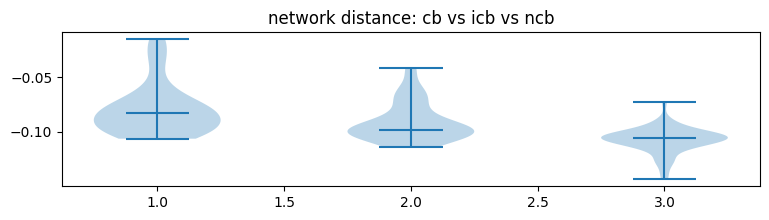

In [11]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9, 2))
axs.violinplot([nd_cb_minus,nd_icb_minus,nd_ncb_minus],
                  showmeans=False,
                  showmedians=True)
axs.set_title('network distance: cb vs icb vs ncb')

In [12]:
df_os["nd"] = df_os[1] - df_os[2]
from lifelines import CoxPHFitter
df_os1 = df_os[["nd",'OS', 'OS_CNSR']]
cph = CoxPHFitter()
cph.fit(df_os1, duration_col='OS', event_col='OS_CNSR')
print(cph.summary)

                coef     exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                      
nd        -29.019333  2.494961e-13  6.922569       -42.58732      -15.451346   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
nd                3.195671e-19         1.947895e-07     0.0 -4.191989   

                  p   -log2(p)  
covariate                       
nd         0.000028  15.142258  


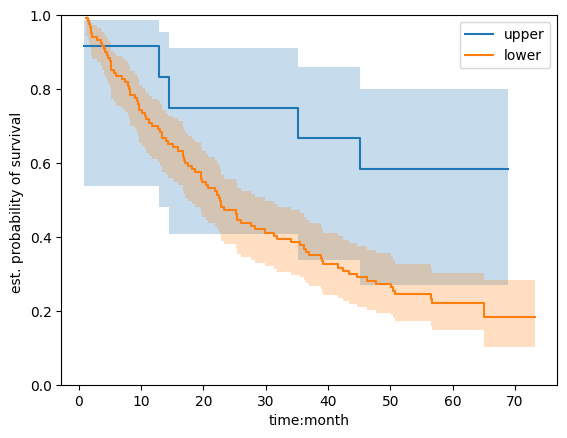

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

df_os["OS_CNSR"] = df_os["OS_CNSR"]==1
tar ="nd"
time, survival_prob, conf_int = kaplan_meier_estimator(
    df_os[df_os[tar]>-0.065]["OS_CNSR"], \
    df_os[df_os[tar]>-0.065]["OS"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post", label="upper")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

time, survival_prob, conf_int = kaplan_meier_estimator(
    df_os[df_os[tar]<-0.065]["OS_CNSR"], \
    df_os[df_os[tar]<-0.065]["OS"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post", label="lower")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel("est. probability of survival ")
plt.xlabel("time:month")
plt.legend(loc="best")

In [14]:
from sksurv.compare import compare_survival
import numpy as np
y = df_os[["OS_CNSR","OS"]].values
y = np.array([ (i[0],i[1]) for i in y],dtype="bool,f")

#df_os_fl[df_os_fl[tar]>df_os[tar].quantile(0.65)] = "higher"
group_indicator = ["high" if i > -0.065 else "low" for i in df_os[tar]] 

chi2, pvalue= compare_survival(y,group_indicator)

print(chi2, pvalue)

5.082211077065679 0.024172524825805036


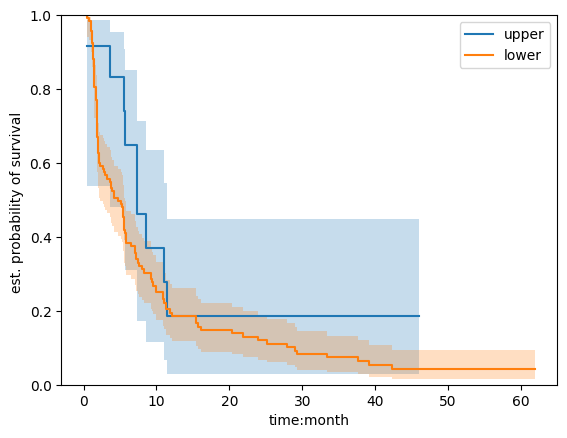

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

df_os["PFS_CNSR"] = df_os["PFS_CNSR"]==1
tar ="nd"
time, survival_prob, conf_int = kaplan_meier_estimator(
    df_os[df_os[tar]>-0.065]["PFS_CNSR"], \
    df_os[df_os[tar]>-0.065]["PFS"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post", label="upper")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

time, survival_prob, conf_int = kaplan_meier_estimator(
    df_os[df_os[tar]<-0.065]["PFS_CNSR"], \
    df_os[df_os[tar]<-0.065]["PFS"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post", label="lower")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.ylabel("est. probability of survival ")
plt.xlabel("time:month")
plt.legend(loc="best")

In [16]:
from sksurv.compare import compare_survival
import numpy as np
y = df_os[["PFS_CNSR","PFS"]].values
y = np.array([ (i[0],i[1]) for i in y],dtype="bool,f")

#df_os_fl[df_os_fl[tar]>df_os[tar].quantile(0.65)] = "higher"
group_indicator = ["high" if i > -0.065 else "low" for i in df_os[tar]] 

chi2, pvalue= compare_survival(y,group_indicator)

print(chi2, pvalue)

2.50868138974086 0.1132206317716273
